## Supplementing the statistics results

In [1]:
import reframed
import pandas as pd

from reframed.cobra import auxotrophy

In [2]:
import sys
sys.path.append("../functions/")
import general_functions as general_func

import colors_MAGs as color_func

In [3]:
from sklearn.metrics.pairwise import pairwise_distances
import scipy.spatial as sp
import scipy.cluster.hierarchy as hc
import seaborn as sns

## Read data 

In [4]:
all_mag_paper = general_func.read_allmags_data()

In [5]:
MAG2community_id = pd.read_csv("../output/MAG2community_id.tsv",sep="\t",header=None)
MAG2community_id.columns=["MAG","community"]
MAG2community_id = MAG2community_id[MAG2community_id["MAG"].isin(all_mag_paper[all_mag_paper.new_coverage>1].index)].copy()
MAG2community_id

,MAG,community
0,CH13-bin.12,CD_A
1,CH13-bin.11,CD_A
2,CH13-bin.4,CD_A
3,CH13-bin.14,CD_A
4,CH13-bin.25,CD_A
...,...,...
68,CH1-bin.1,M_P
69,CH1-bin.10,M_P
70,CH3-bin.2,M_X
71,CH3-bin.1,M_X


**Media**

In [6]:
media_db = pd.read_csv("https://raw.githubusercontent.com/cdanielmachado/carveme/master/carveme/data/input/media_db.tsv",sep="\t")
m9_env_db = media_db[media_db.medium=="M9[-O2]"]
m9_env = reframed.Environment.from_compounds(m9_env_db.compound.values)


lb_db = media_db[media_db.medium=="LB[-O2]"]

**Colors**

In [7]:

phyla_lut, unique_phyla, phylum_colors = color_func.phylum_colors_func()

chebi_lut,chebi_interesting,chebi_colors_ser = color_func.chebi_rxn_color_func()

In [8]:
colrs_df = phylum_colors.copy()


### Load models

In [9]:
GEMs_dict = {}

for MAG in MAG2community_id["MAG"].values:
    
    GEMs_dict[MAG]=reframed.load_cbmodel("../output/GEMs/GEMs_final/"+MAG+".xml", flavor="bigg")

In [10]:
model_uni = reframed.load_cbmodel("../input/universe_bacteria.xml")

## 0. General results

In [11]:
from matplotlib.pyplot import gcf

### Auxotrophies

In [12]:
all_gems_auxo={}

lb_env = reframed.Environment.from_compounds(lb_db.compound.values)

lb_env["R_EX_gua_e"]=(-1000,0)

for MAG in GEMs_dict.keys():
    model = GEMs_dict[MAG]
    
    lb_env.apply(model,inplace=True,warning=False)
    specific_env = reframed.Environment.from_model(model)
    
    auxo = auxotrophy.auxotrophies(model,specific_env)
    
    all_gems_auxo[MAG]=auxo

Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-14


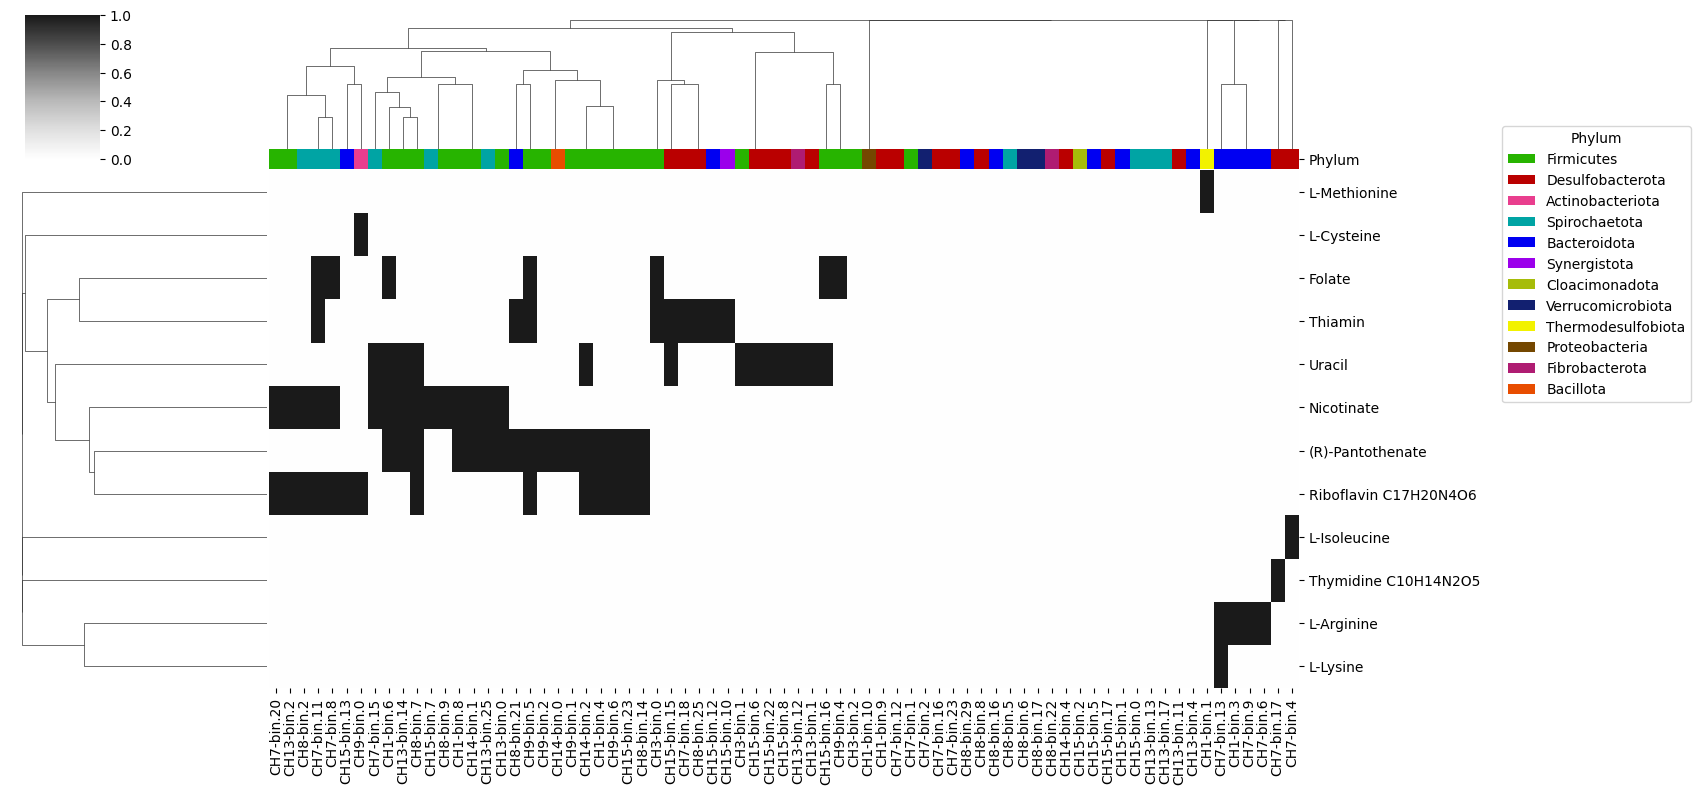

In [13]:
summary_auxo = {}

for key,value in all_gems_auxo.items():
    summary_auxo[key]={}
    for rxn in value:
        summary_auxo[key][rxn]=1
summary_auxo_df = pd.DataFrame(summary_auxo).fillna(0)
summary_auxo_df = summary_auxo_df.loc[~summary_auxo_df.index.isin(["R_EX_"+met+"_e" for met in m9_env_db.compound.values])]

rxn2met = {rxn:model_uni.reactions[rxn].get_substrates()[0] for rxn in model.reactions if rxn.startswith("R_EX_")}
rxn2met["R_EX_nac_e"] = "M_nac_e"
rxn2met["R_EX_pnto__R_e"] = "M_pnto__R_e"
rxn2met["R_EX_ins_e"] = "M_ins_e"
rxn2met["R_EX_adn_e"] = "M_adn_e"
rxn2met["R_EX_gsn_e"] = "M_gsn_e"
rxn2met["R_EX_cmp_e"] = "M_cmp_e"

summary_auxo_df.index = summary_auxo_df.index.map(lambda x: model_uni.metabolites[rxn2met[x]])


fig = sns.clustermap(data=summary_auxo_df, 
               cmap="RdGy",
               center=0,
               method="average",
               metric="jaccard",
               col_colors=colrs_df,
               z_score=None,
               standard_scale=None,
               xticklabels=True,
               yticklabels=True,
               figsize=(15,8)             )

for label in unique_phyla:
    fig.ax_col_dendrogram.bar(0, 0, color=phyla_lut[label], label=label, linewidth=0)

l1 = fig.ax_col_dendrogram.legend(title='Phylum',ncol=1, bbox_to_anchor=(1.0, 0.85), loc='upper left',bbox_transform=gcf().transFigure)


### Minimal medium

In [20]:
all_GEMs_minimal_medium={}
n_solutions = 50

for MAG in GEMs_dict.keys():

    model = GEMs_dict[MAG].copy()
    all_ex_rxns = list(lb_env.keys())                     
    ex_rxns =  [ex_rxn for ex_rxn in all_ex_rxns if ex_rxn in model.reactions]

    min_medium = reframed.cobra.medium.minimal_medium(model=model,exchange_reactions=ex_rxns,use_pool=True,n_solutions=n_solutions)
    
    all_GEMs_minimal_medium[MAG]=min_medium

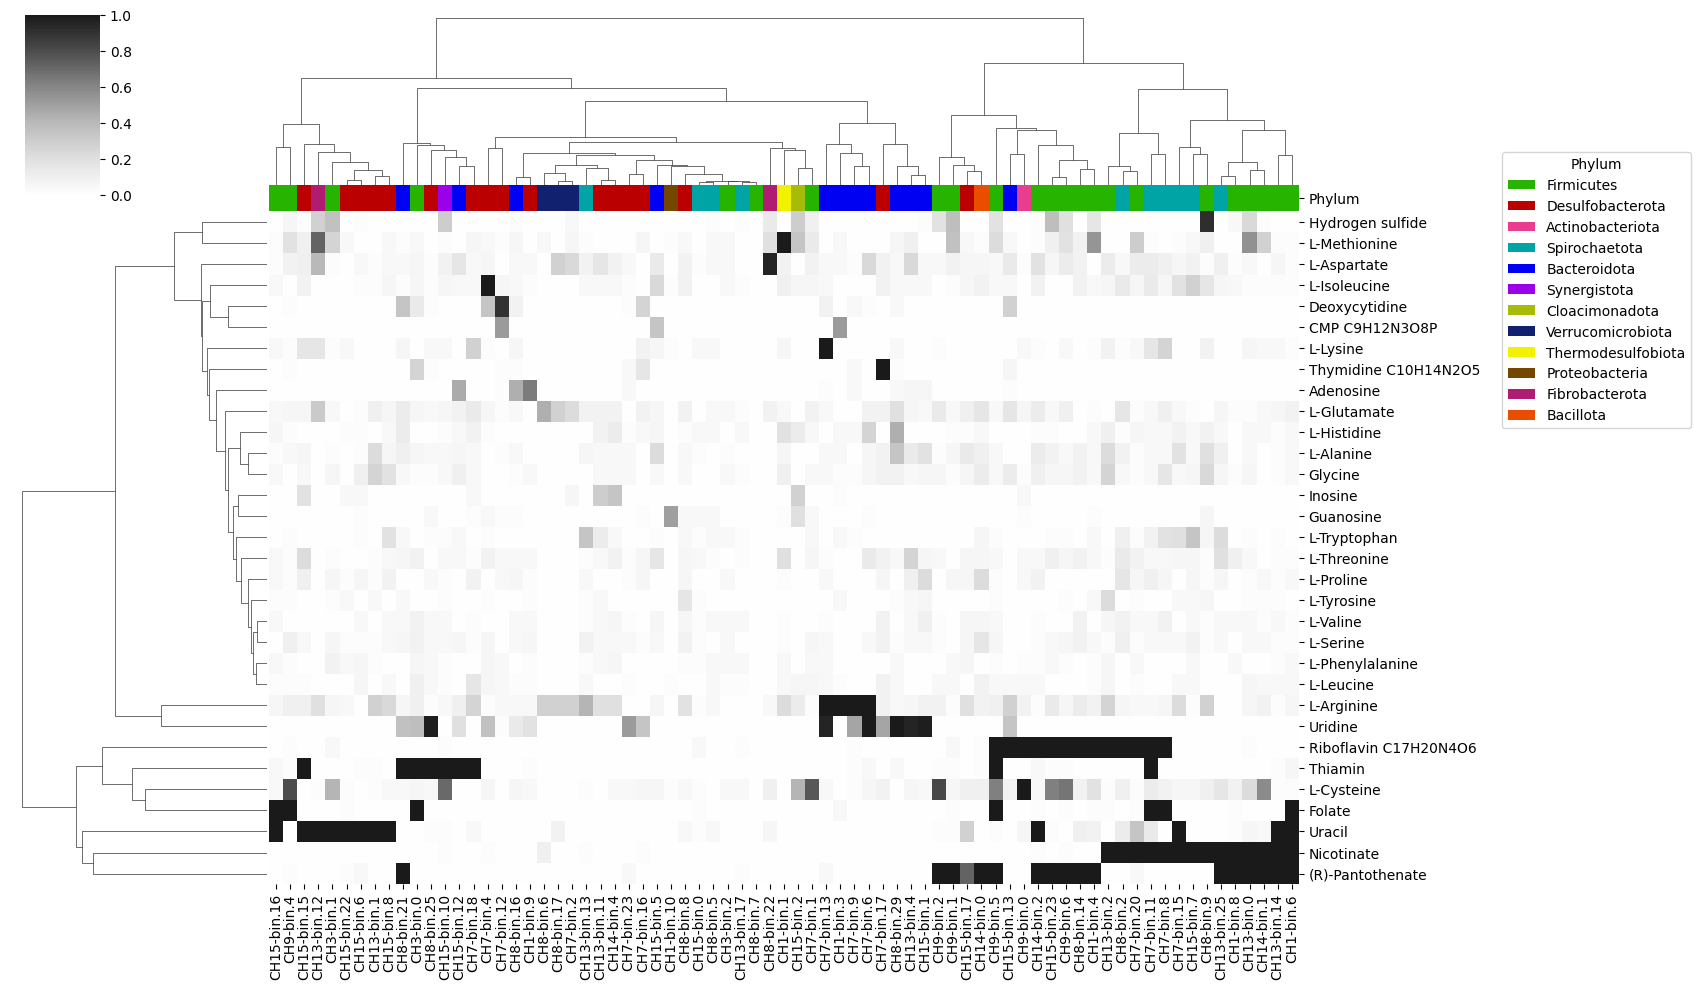

In [21]:
summary = {}
for key, value in all_GEMs_minimal_medium.items():
    
    solutions = value[0]
    summary[key]={}
    for solution in solutions:
        
        for element in solution:
            if element in summary[key].keys():
                summary[key][element] +=1
            else:
                summary[key][element] = 1

summary_df = pd.DataFrame(summary).fillna(0).apply(lambda x:x/n_solutions)
summary_df = summary_df.loc[~(summary_df.index.isin(m9_env.keys())) & (summary_df.sum(axis=1)>1)]



summary_df.index = summary_df.index.map(lambda x: model_uni.metabolites[rxn2met[x]])


fig = sns.clustermap(data=summary_df,
               cmap="RdGy",
               center=0,
               method="ward",
               metric="euclidean",
               col_colors=colrs_df,
               xticklabels=True,
               yticklabels=True,
              figsize=(15,10))

for label in unique_phyla:
    fig.ax_col_dendrogram.bar(0, 0, color=phyla_lut[label], label=label, linewidth=0)

l1 = fig.ax_col_dendrogram.legend(title='Phylum',ncol=1, bbox_to_anchor=(1.0, 0.85), loc='upper left',bbox_transform=gcf().transFigure)


### Compound producers

In [23]:
special_compounds = list(set(lb_db.compound.values) - set(m9_env_db.compound.values))

In [24]:
special_compounds.append("orn__L")
special_compounds.append("thym")
special_compounds.append("lac__L")
special_compounds.append("mal__L")
special_compounds.append("ppa")
special_compounds.append("2mpa")
special_compounds.append("but")
special_compounds.append("hxa")


In [25]:
m9_env = reframed.Environment.from_compounds(m9_env_db.compound.values)

compound_producer = {}

for MAG in GEMs_dict.keys():
    print(MAG)
    compound_producer[MAG]={}
    model = GEMs_dict[MAG].copy()
    m9_env.apply(model,inplace=True,warning=False)
    
    for compound in special_compounds:
        if "R_EX_"+compound+"_e" in model.reactions:
            sol = reframed.FBA(model,objective={"R_EX_"+compound+"_e":1,"R_Growth":0})
            compound_producer[MAG][compound] = sol.fobj>1e-6
        else:
            compound_producer[MAG][compound]=False

CH13-bin.12
CH13-bin.11
CH13-bin.4
CH13-bin.14
CH13-bin.25
CH13-bin.17
CH13-bin.0
CH13-bin.1
CH13-bin.13
CH13-bin.2
CH15-bin.0
CH15-bin.23
CH15-bin.1
CH15-bin.7
CH15-bin.8
CH15-bin.22
CH15-bin.6
CH15-bin.17
CH15-bin.16
CH15-bin.13
CH15-bin.12
CH15-bin.5
CH15-bin.10
CH15-bin.15
CH15-bin.2
CH14-bin.1
CH14-bin.2
CH14-bin.4
CH14-bin.0
CH8-bin.22
CH8-bin.17
CH8-bin.7
CH8-bin.2
CH8-bin.6
CH8-bin.25
CH8-bin.5
CH8-bin.9
CH8-bin.16
CH8-bin.21
CH8-bin.8
CH8-bin.29
CH8-bin.14
CH7-bin.23
CH7-bin.16
CH7-bin.11
CH7-bin.13
CH7-bin.2
CH7-bin.8
CH7-bin.18
CH7-bin.1
CH7-bin.17
CH7-bin.4
CH7-bin.12
CH7-bin.20
CH7-bin.9
CH7-bin.6
CH7-bin.15
CH9-bin.0
CH9-bin.6
CH9-bin.5
CH9-bin.1
CH9-bin.2
CH9-bin.4
CH1-bin.6
CH1-bin.9
CH1-bin.3
CH1-bin.4
CH1-bin.8
CH1-bin.1
CH1-bin.10
CH3-bin.2
CH3-bin.1
CH3-bin.0


In [26]:
compound_producer_df = pd.DataFrame(compound_producer)
compound_producer_df = compound_producer_df.loc[compound_producer_df.sum(axis=1)>0]

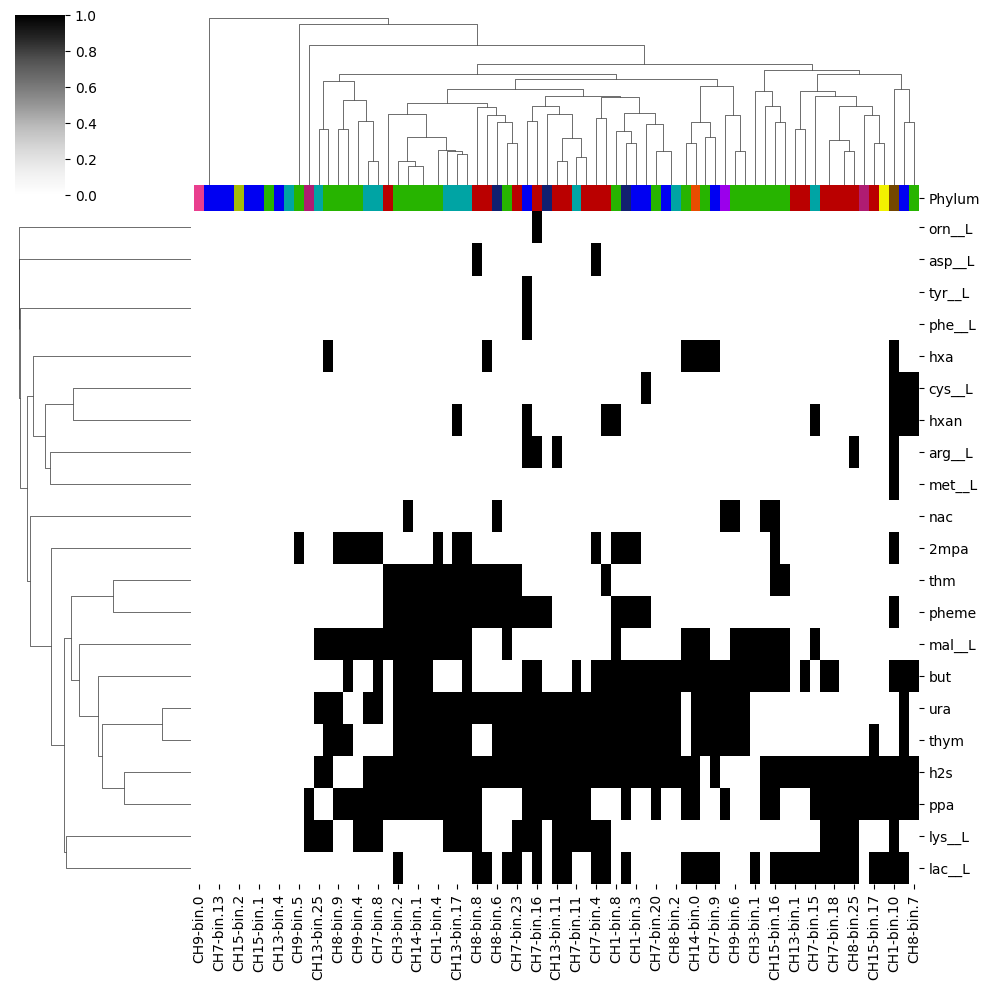

In [27]:
sns.clustermap(data=compound_producer_df, cmap="Greys",method="average",metric="jaccard",col_colors=colrs_df,yticklabels=True)

### Steadiercom solutions

In [29]:
SC1_C = pd.read_csv("../output/steadiercom_sample_0.1.3/results/results_99_SC1_C.tsv",sep="\t")
SC2_C = pd.read_csv("../output/steadiercom_sample_0.1.3/results/results_99_SC2_C.tsv",sep="\t")
SC1_X = pd.read_csv("../output/steadiercom_sample_0.1.3/results/results_99_SC1_X.tsv",sep="\t")

steadier_sample = pd.concat([SC1_C,SC2_C,SC1_X])
steadier_sample = steadier_sample[(steadier_sample.frequency>0.1) & (steadier_sample.rate>1e-6)]
steadier_sample["mass_rate*frequency"] = steadier_sample["mass_rate"]*steadier_sample["frequency"]
steadier_sample_cross = steadier_sample[(steadier_sample.donor!="environment")&(steadier_sample.receiver!="environment")].copy()

In [30]:
steadiercom_receiver= steadier_sample_cross.groupby(["receiver","compound"]).mean()["mass_rate*frequency"].unstack().fillna(0).T
steadiercom_receiver = steadiercom_receiver[steadiercom_receiver.sum(axis=1)>1e-6].copy()

In [31]:
steadiercom_donor= steadier_sample_cross.groupby(["donor","compound"]).mean()["mass_rate*frequency"].unstack().fillna(0).T
steadiercom_donor = steadiercom_donor[steadiercom_donor.sum(axis=1)>1e-6].copy()

## 1. Sphaerochaetaceae receives and donates more Glucose

Conclusion: All the members that receive glucose are also donating it (5 overlap, of 5 receiving and donating). Members that donate or receive glucose to/from Spirochaeataceae are only in one category when it comes to receiving or donating (no overlap between donators and receivers)

In [32]:
Sphaerochaetaceae_MAGs = all_mag_paper[(all_mag_paper["Family"]=="Sphaerochaetaceae") & (all_mag_paper.new_coverage>1)].index
Sphaerochaetaceae_MAGs

Index(['CH15-bin.7', 'CH7-bin.11', 'CH7-bin.8', 'CH7-bin.15', 'CH13-bin.25',
       'CH8-bin.2'],
      dtype='object', name='MAG')

In [33]:
all_mag_paper[(all_mag_paper.index.isin(Sphaerochaetaceae_MAGs))]

,Source,Substrate,Completeness (%),Contamination (%),Domain,Phylum,Class,Order,Family,Genus,Species,Genome size (bp),Scaffolds,N50,CDS prediction (DRAM),Column1,new_coverage
MAG,,,,,,,,,,,,,,,,,
CH15-bin.7,Compost_Digestate,PASC,98.86,1.14,Bacteria,Spirochaetota,Spirochaetia,Sphaerochaetales,Sphaerochaetaceae,Sphaerochaeta,Sphaerochaeta sp012514185,3131435.0,51.0,117918.0,2906.0,CH15-bin.7,7.856837
CH7-bin.11,Cow_Manure,PASC,94.25,0.00,Bacteria,Spirochaetota,Spirochaetia,Sphaerochaetales,Sphaerochaetaceae,Sphaerochaeta,NaN,2757910.0,86.0,52253.0,2535.0,CH7-bin.11,8.088421
CH7-bin.8,Cow_Manure,PASC,95.05,0.00,Bacteria,Spirochaetota,Spirochaetia,Sphaerochaetales,Sphaerochaetaceae,Sphaerochaeta,Sphaerochaeta sp012511235,3244483.0,52.0,120731.0,3054.0,CH7-bin.8,3.747918
CH7-bin.15,Cow_Manure,PASC,98.80,2.27,Bacteria,Spirochaetota,Spirochaetia,Sphaerochaetales,Sphaerochaetaceae,NaN,NaN,3033777.0,113.0,51835.0,2869.0,CH7-bin.15,1.014965
CH13-bin.25,Compost_Digestate,Avicel,98.86,2.27,Bacteria,Spirochaetota,Spirochaetia,Sphaerochaetales,Sphaerochaetaceae,Sphaerochaeta,Sphaerochaeta sp012514185,3203701.0,58.0,117413.0,2965.0,CH13-bin.25,6.692789
CH8-bin.2,Cow_Manure,Avicel,95.45,0.00,Bacteria,Spirochaetota,Spirochaetia,Sphaerochaetales,Sphaerochaetaceae,Sphaerochaeta,NaN,2908104.0,163.0,32809.0,2664.0,CH8-bin.2,5.387587


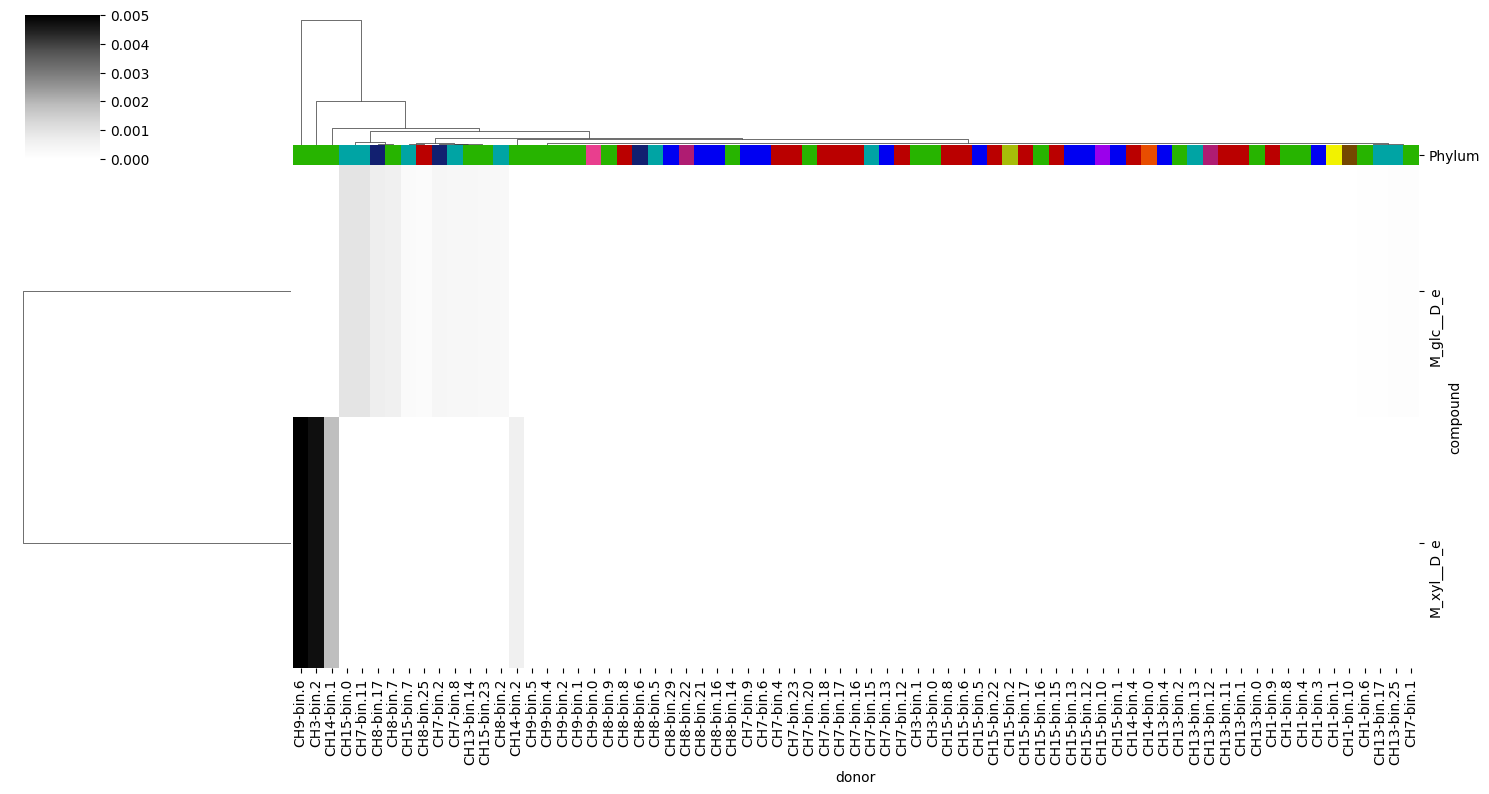

In [34]:

sns.clustermap(figsize=(15,8),data=steadiercom_donor.loc[["M_glc__D_e","M_xyl__D_e"]],
               cmap="Greys",
               vmin=0, 
               vmax=0.005,
               method="ward",
               metric="euclidean",
               col_colors=colrs_df,
               yticklabels=True,
               xticklabels=True)

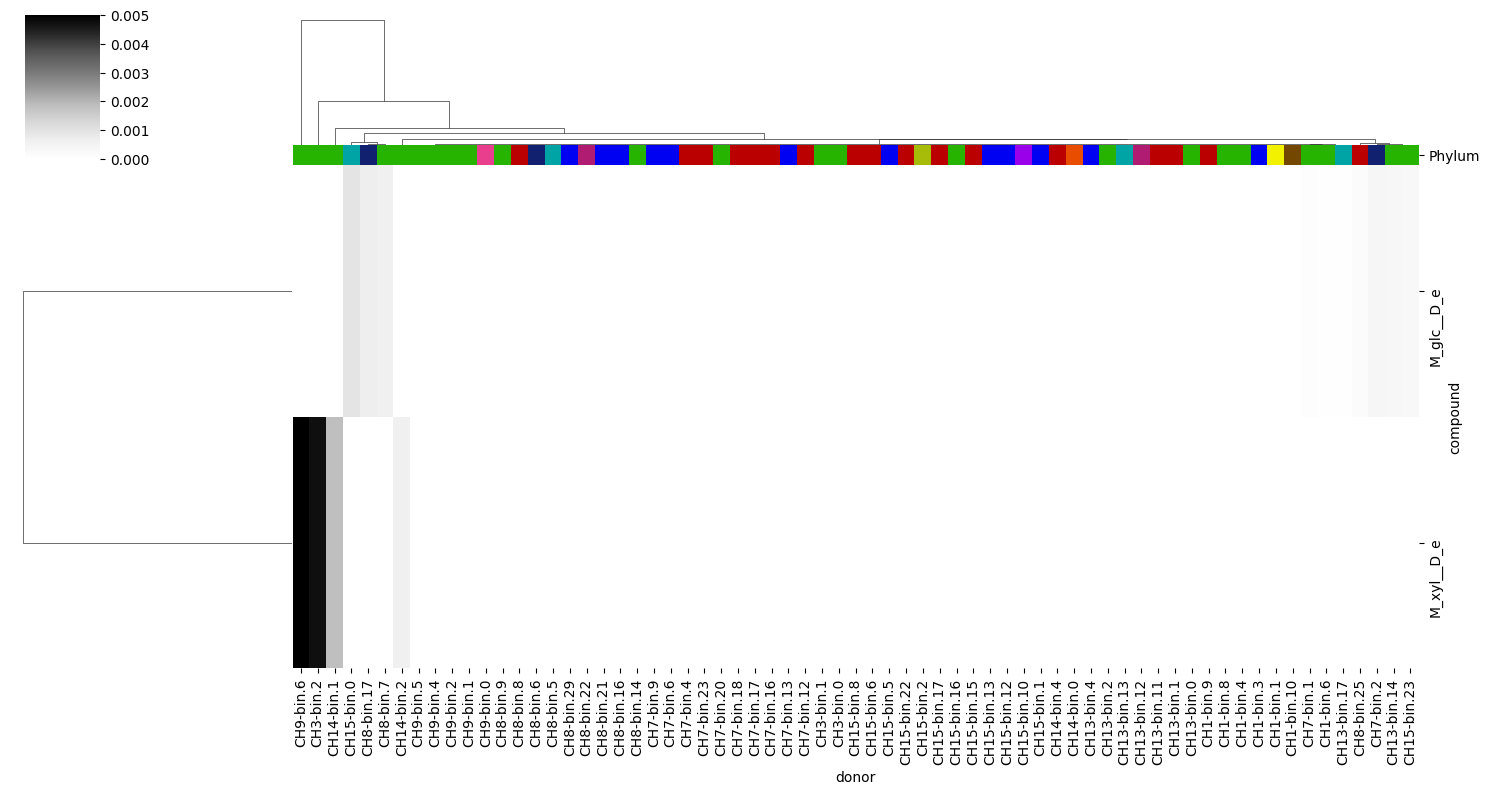

In [35]:

sns.clustermap(figsize=(15,8),
               data=steadiercom_donor.loc[["M_glc__D_e","M_xyl__D_e"],~(steadiercom_donor.columns.isin(Sphaerochaetaceae_MAGs))],
               cmap="Greys",
               vmin=0, 
               vmax=0.005,
               method="ward",
               metric="euclidean",
               col_colors=colrs_df,
               yticklabels=True,
               xticklabels=True)

In [36]:
steadiercom_donor.loc["M_glc__D_e",Sphaerochaetaceae_MAGs]

MAG
CH15-bin.7     0.000232
CH7-bin.11     0.000961
CH7-bin.8      0.000341
CH7-bin.15     0.000000
CH13-bin.25    0.000103
CH8-bin.2      0.000304
Name: M_glc__D_e, dtype: float64

In [37]:
steadiercom_receiver.loc["M_glc__D_e",Sphaerochaetaceae_MAGs]

MAG
CH15-bin.7     0.001329
CH7-bin.11     0.000716
CH7-bin.8      0.000180
CH7-bin.15     0.000000
CH13-bin.25    0.000541
CH8-bin.2      0.000764
Name: M_glc__D_e, dtype: float64

In [38]:
steadier_sample_cross[(steadier_sample_cross.donor.isin(Sphaerochaetaceae_MAGs)) & (steadier_sample_cross.receiver.isin(Sphaerochaetaceae_MAGs)) & (steadier_sample_cross.compound=="M_glc__D_e")]

,donor,receiver,compound,mass_rate,rate,frequency,community,medium,mass_rate*frequency
41,CH7-bin.8,CH7-bin.11,M_glc__D_e,0.004670,0.025922,0.16,CM_P,SC2_C,0.000747
151,CH7-bin.11,CH7-bin.8,M_glc__D_e,0.000949,0.005268,0.19,CM_P,SC2_C,0.000180


In [39]:
Sphaerochaetaceae_donates = steadier_sample_cross[((steadier_sample_cross.donor.isin(Sphaerochaetaceae_MAGs))) & (steadier_sample_cross.compound=="M_glc__D_e") & (steadier_sample_cross.frequency>0.1)  ].sort_values(["mass_rate"])
Sphaerochaetaceae_donates

,donor,receiver,compound,mass_rate,rate,frequency,community,medium,mass_rate*frequency
234,CH13-bin.25,CH13-bin.1,M_glc__D_e,0.000303,0.001682,0.34,CD_A,SC1_C,0.000103
214,CH7-bin.11,CH7-bin.18,M_glc__D_e,0.000618,0.003433,0.21,CM_P,SC2_C,0.000130
185,CH7-bin.8,CH7-bin.17,M_glc__D_e,0.000789,0.004381,0.19,CM_P,SC2_C,0.000150
179,CH7-bin.11,CH7-bin.17,M_glc__D_e,0.000816,0.004530,0.50,CM_P,SC2_C,0.000408
151,CH7-bin.11,CH7-bin.8,M_glc__D_e,0.000949,0.005268,0.19,CM_P,SC2_C,0.000180
143,CH7-bin.11,CH7-bin.1,M_glc__D_e,0.001019,0.005659,0.29,CM_P,SC2_C,0.000296
140,CH7-bin.8,CH7-bin.1,M_glc__D_e,0.001038,0.005763,0.12,CM_P,SC2_C,0.000125
95,CH15-bin.7,CH15-bin.17,M_glc__D_e,0.001274,0.007072,0.15,CD_P,SC1_C,0.000191
82,CH15-bin.7,CH15-bin.13,M_glc__D_e,0.001411,0.007833,0.15,CD_P,SC1_C,0.000212
85,CH8-bin.2,CH8-bin.6,M_glc__D_e,0.002028,0.011255,0.15,CM_A,SC2_C,0.000304


In [40]:
Sphaerochaetaceae_receives = steadier_sample_cross[((steadier_sample_cross.receiver.isin(Sphaerochaetaceae_MAGs))) & (steadier_sample_cross.compound=="M_glc__D_e") & (steadier_sample_cross.frequency>0.1)].sort_values(["mass_rate"])
Sphaerochaetaceae_receives

,donor,receiver,compound,mass_rate,rate,frequency,community,medium,mass_rate*frequency
151,CH7-bin.11,CH7-bin.8,M_glc__D_e,0.000949,0.005268,0.19,CM_P,SC2_C,0.000180
73,CH8-bin.7,CH8-bin.2,M_glc__D_e,0.002600,0.014434,0.27,CM_A,SC2_C,0.000702
36,CH13-bin.14,CH13-bin.25,M_glc__D_e,0.002706,0.015020,0.20,CD_A,SC1_C,0.000541
63,CH8-bin.17,CH8-bin.2,M_glc__D_e,0.002948,0.016363,0.28,CM_A,SC2_C,0.000825
41,CH7-bin.8,CH7-bin.11,M_glc__D_e,0.004670,0.025922,0.16,CM_P,SC2_C,0.000747
13,CH15-bin.0,CH15-bin.7,M_glc__D_e,0.004922,0.027318,0.27,CD_P,SC1_C,0.001329
36,CH7-bin.2,CH7-bin.11,M_glc__D_e,0.005262,0.029210,0.13,CM_P,SC2_C,0.000684


**How many different receivers of the glucose from Sphaerochaetaceae?**

In [41]:
len(set(Sphaerochaetaceae_donates.receiver.values))

11

**How many different donators of the glucose to Sphaerochaetaceae?**

In [42]:
len(set(Sphaerochaetaceae_receives.donor.values))

7

**How many of the receivers of glucose from Sphaerochaetaceae are also donating to Sphaerochaetaceae?**

This has to be the sharing withing the two members of the Sphaerochaetaceae family.

In [43]:
len(set(Sphaerochaetaceae_donates.receiver.values).intersection(set(Sphaerochaetaceae_receives.donor.values)))

2

**How many of the Sphaerochaetaceae donating are the same as the ones receiving?**

In [44]:
len(set(Sphaerochaetaceae_donates.donor.values).intersection(set(Sphaerochaetaceae_receives.receiver.values)))

5

**Number of Sphaerochaetaceae receiving**

In [45]:
len(set(Sphaerochaetaceae_receives.receiver.values))

5

**Number of Sphaerochaetaceae donating**

In [46]:
len(set(Sphaerochaetaceae_receives.donor.values))

7

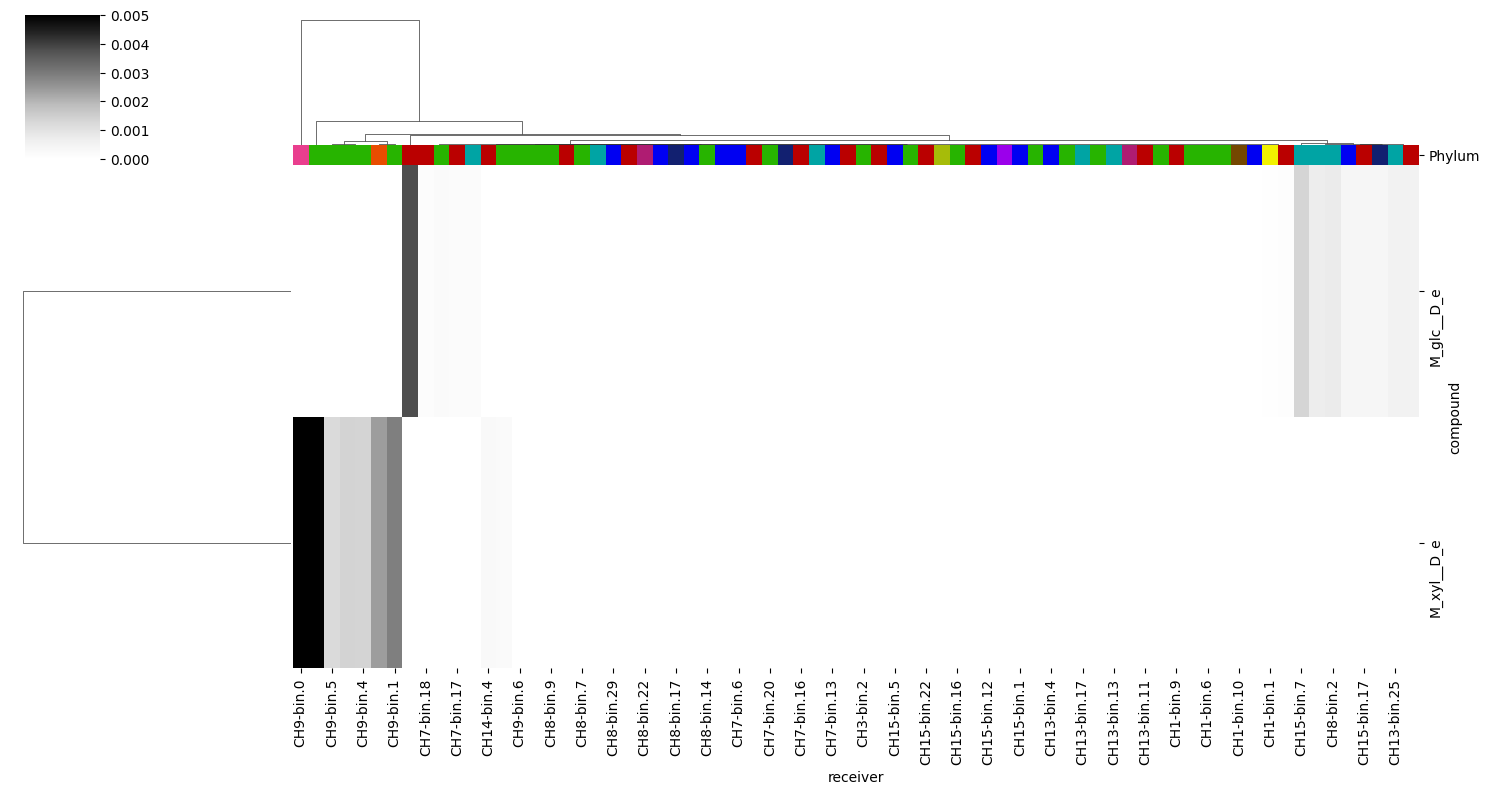

In [47]:

sns.clustermap(figsize=(15,8),data=steadiercom_receiver.loc[["M_glc__D_e","M_xyl__D_e"]],cmap="Greys",vmin=0,vmax=0.005, method="ward",metric="euclidean",col_colors=colrs_df,yticklabels=True)

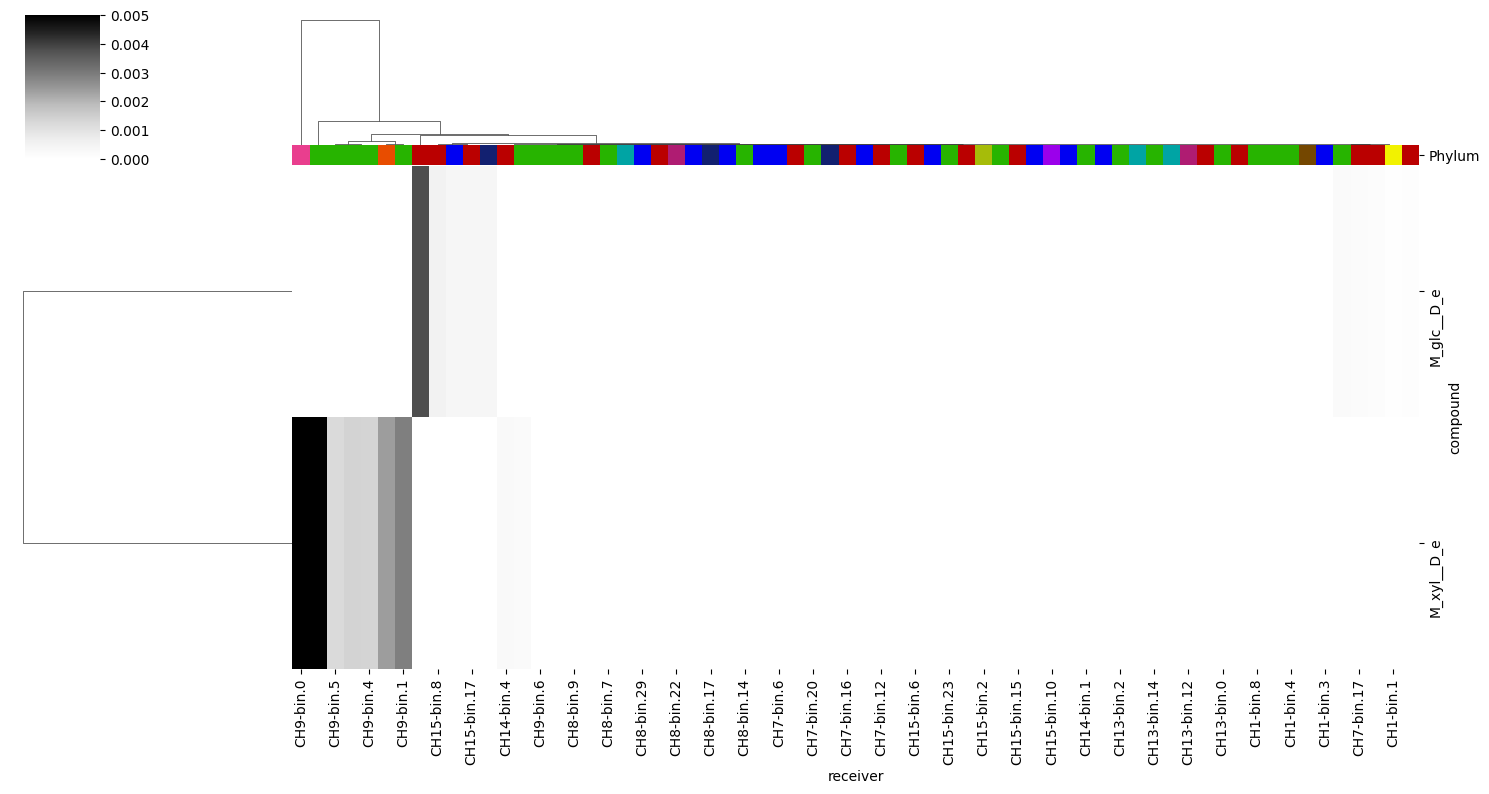

In [48]:

sns.clustermap(figsize=(15,8),data=steadiercom_receiver.loc[["M_glc__D_e","M_xyl__D_e"],~(steadiercom_receiver.columns.isin(Sphaerochaetaceae_MAGs))],cmap="Greys",vmin=0,vmax=0.005, method="ward",metric="euclidean",col_colors=colrs_df,yticklabels=True)

## 3.a Lachnospiraceae is sharing guanine

Conclusion: This might be biologically significant.
- From production clustermap from simple compounds no member can produce guanine. 
- From the steadiercom solutions few members seem to be donating the compound and they are almost all in the Firmicutes phylum

In [52]:
"gua" in compound_producer_df.index

False

In [53]:
Lachnospiraceae_MAGs =  all_mag_paper[(all_mag_paper["Family"]=="Lachnospiraceae") & (all_mag_paper.new_coverage>1)].index


In [54]:
all_mag_paper[all_mag_paper.index.isin(Lachnospiraceae_MAGs)].groupby(["Source","Substrate"]).count()

Completeness (%)  Contamination (%)  Domain  \
Source            Substrate                                                
Compost_Digestate Avicel                    2                  2       2   
                  PASC                      1                  1       1   
                  Xylan                     2                  2       2   
Cow_Manure        Xylan                     1                  1       1   
Marshland         PASC                      2                  2       2   

                             Phylum  Class  Order  Family  Genus  Species  \
Source            Substrate                                                 
Compost_Digestate Avicel          2      2      2       2      2        2   
                  PASC            1      1      1       1      1        0   
                  Xylan           2      2      2       2      2        2   
Cow_Manure        Xylan           1      1      1       1      1        1   
Marshland         PASC            2      2      2       2      2        2   

                             Genome size (bp)  Scaffolds  N50  \
Source            Substrate                                     
Compost_Digestate Avicel                    2          2    2   
                  PASC                      1          1    1   
                  Xylan                     2          2    2   
Cow_Manure        Xylan                     1          1    1   
Marshland         PASC                      2          2    2   

                             CDS prediction (DRAM)  Column1  new_coverage  
Source            Substrate                                                
Compost_Digestate Avicel                         2        2             2  
                  PASC                           1        1             1  
                  Xylan                          2        2             2  
Cow_Manure        Xylan                          1        1             1  
Marshland         PASC                           2        2             2

In [55]:
steadiercom_donor.loc[["M_gua_e","M_ura_e"]]

donor,CH1-bin.1,CH1-bin.10,CH1-bin.3,CH1-bin.4,CH1-bin.6,CH1-bin.8,CH1-bin.9,CH13-bin.0,CH13-bin.1,CH13-bin.11,...,CH8-bin.6,CH8-bin.7,CH8-bin.8,CH8-bin.9,CH9-bin.0,CH9-bin.1,CH9-bin.2,CH9-bin.4,CH9-bin.5,CH9-bin.6
compound,,,,,,,,,,,,,,,,,,,,,
M_gua_e,0.0,0.0,0.0,0.0,0.000044,0.0,0.000000,0.0,0.0,0.000012,...,0.0,0.0,0.0,0.0,0.0,0.000067,0.0,0.0,0.0,0.0
M_ura_e,0.0,0.0,0.0,0.0,0.000000,0.0,0.000038,0.0,0.0,0.000007,...,0.0,0.0,0.0,0.0,0.0,0.000029,0.0,0.0,0.0,0.0


In [56]:
steadiercom_donor.loc[["M_gua_e","M_ura_e"]].max().max()

6.652811223772845e-05

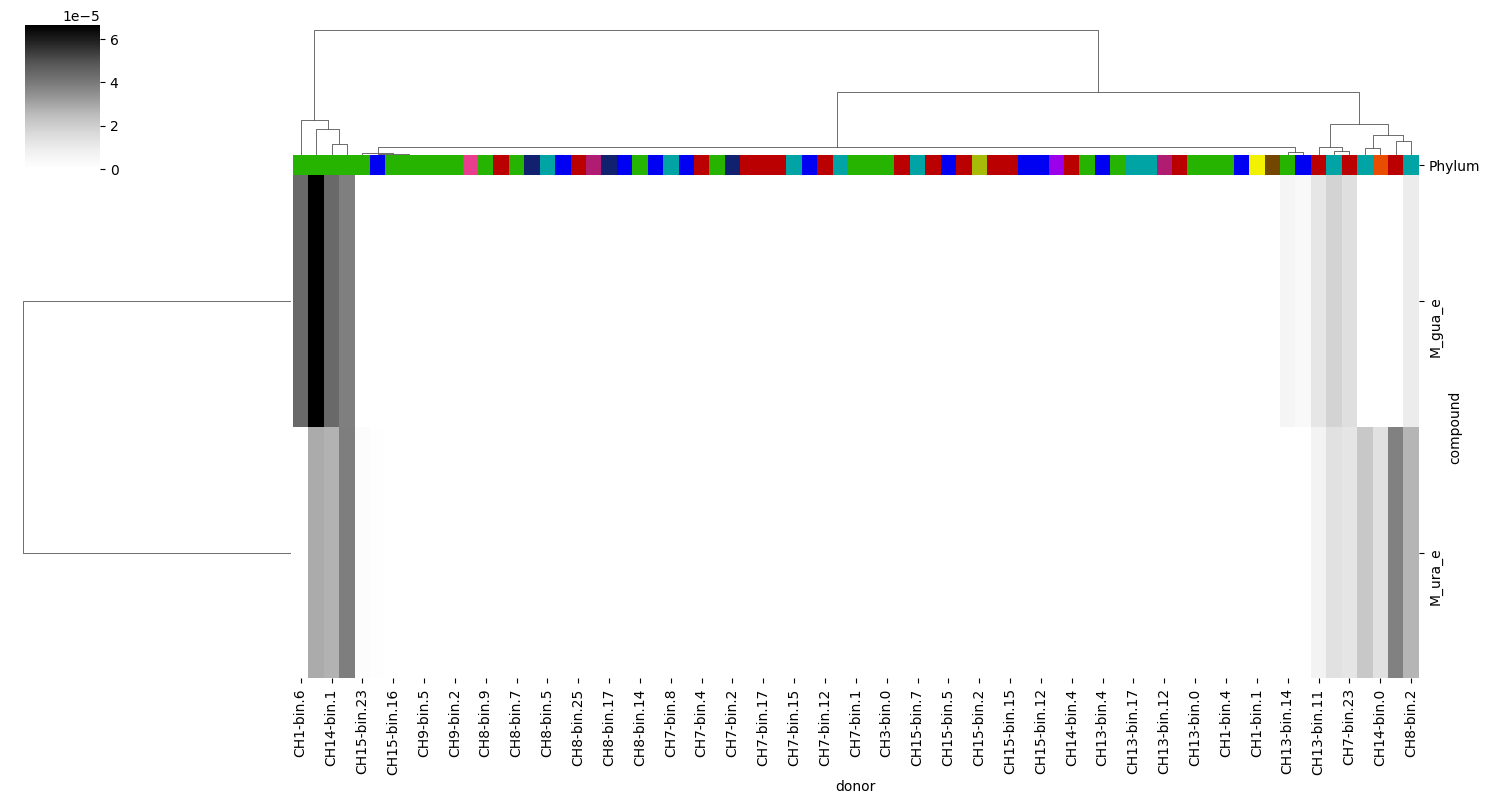

In [57]:

sns.clustermap(figsize=(15,8),
               data=steadiercom_donor.loc[["M_gua_e","M_ura_e"]],
               cmap="Greys",
               vmin=0,
               #vmax=1, 
               method="ward",
               metric="euclidean",
               col_colors=colrs_df,
               yticklabels=True)

**Removing the Lachnospiraceae results in removal of (nearly) all members of the Firmicutes phylum**

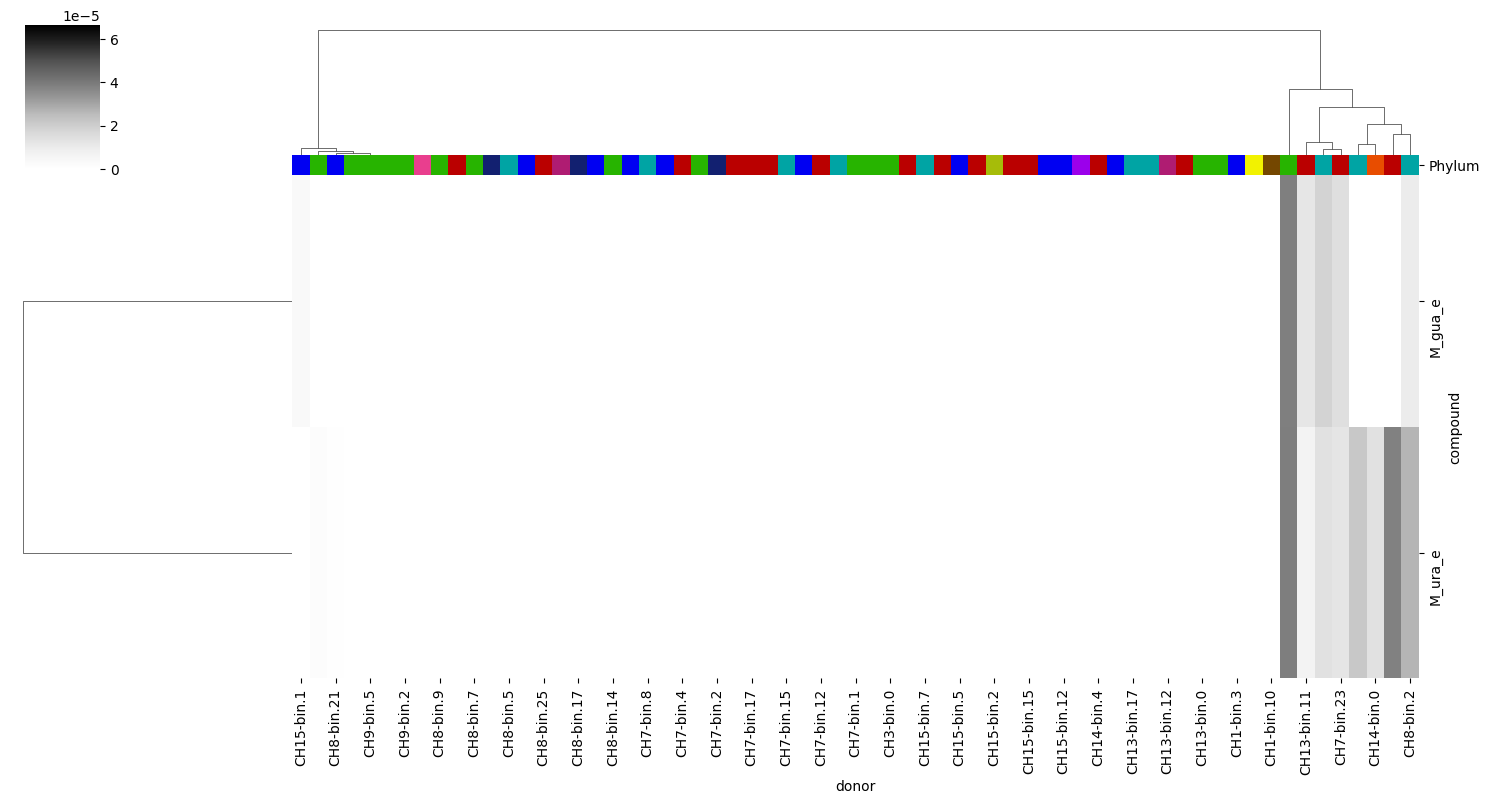

In [58]:
sns.clustermap(figsize=(15,8),
               data=steadiercom_donor.loc[["M_gua_e","M_ura_e"],~(steadiercom_donor.columns.isin(Lachnospiraceae_MAGs))],
               cmap="Greys",
               vmin=0,
               vmax=steadiercom_donor.loc[["M_gua_e","M_ura_e"]].max().max(),
               method="ward",
               metric="euclidean",
               col_colors=colrs_df,
               yticklabels=True)

## 4. f_Desulfovibrionaceae is sharing L-lacate

**Conclusion**: f_Desulfovibrionaceae is contributing with more lactate, but it seems to be less frequently found in our solutions. We should check how big the contribution truly is. 

In [67]:
Desulfovibrionaceae_MAGs =  all_mag_paper[(all_mag_paper["Family"]=="Desulfovibrionaceae") & (all_mag_paper.new_coverage>1)].index


**They are not able to produce any of the compounds in question**

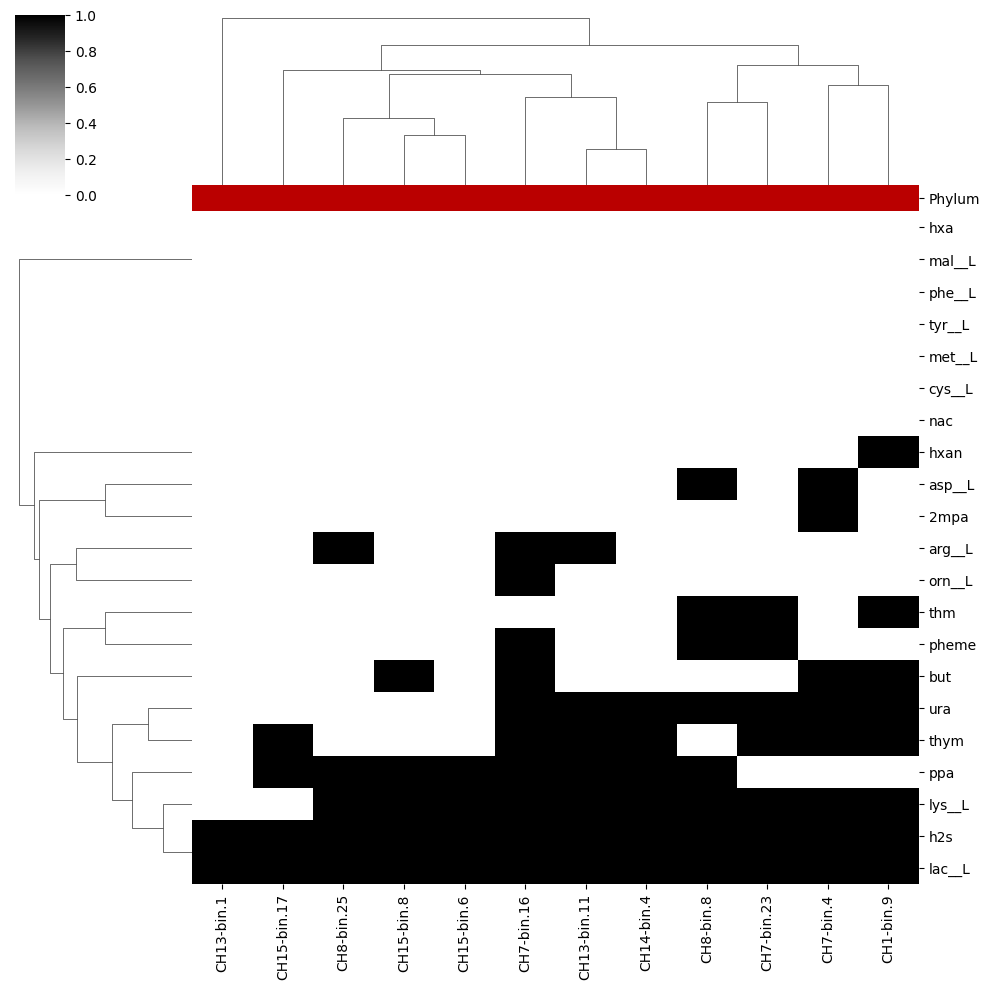

In [68]:
sns.clustermap(data=compound_producer_df.loc[:,compound_producer_df.columns.isin(Desulfovibrionaceae_MAGs)], cmap="Greys",vmin=False,method="average",metric="jaccard",col_colors=colrs_df,yticklabels=True)

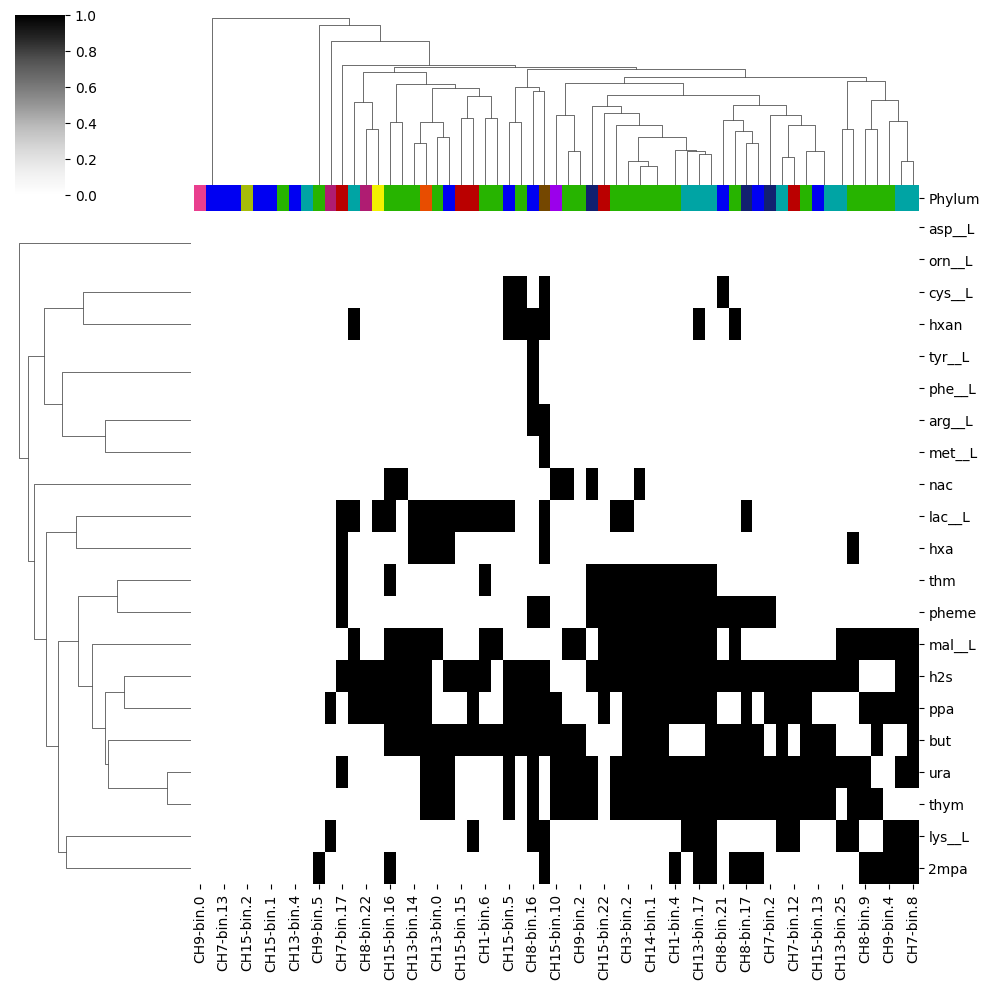

In [69]:
sns.clustermap(data=compound_producer_df.loc[:,~compound_producer_df.columns.isin(Desulfovibrionaceae_MAGs)], cmap="Greys",method="average",metric="jaccard",col_colors=colrs_df,yticklabels=True)

In [70]:
Clostridiaceae_MAGs =  all_mag_paper[(all_mag_paper["Family"]=="Clostridiaceae") & (all_mag_paper.new_coverage>1)].index


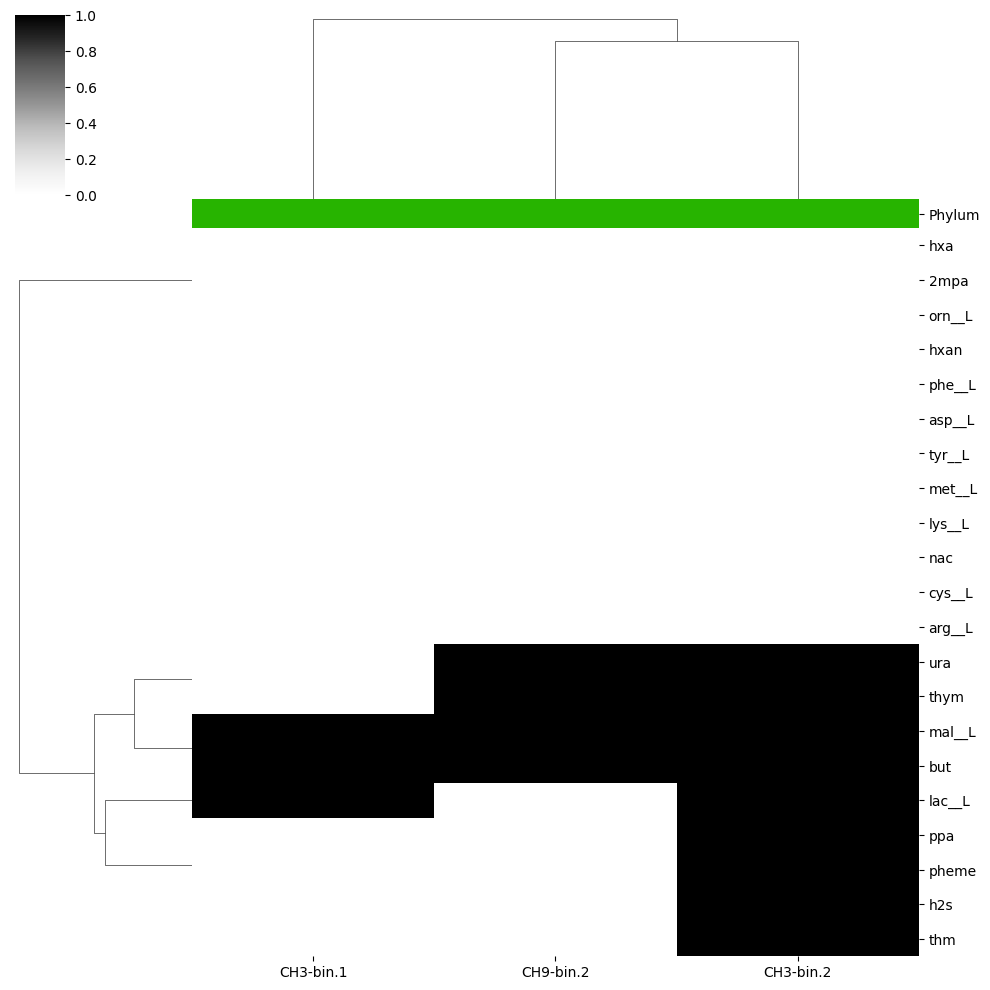

In [71]:
sns.clustermap(data=compound_producer_df.loc[:,compound_producer_df.columns.isin(Clostridiaceae_MAGs)], cmap="Greys",method="average",metric="jaccard",col_colors=colrs_df,yticklabels=True)

### Compound producer

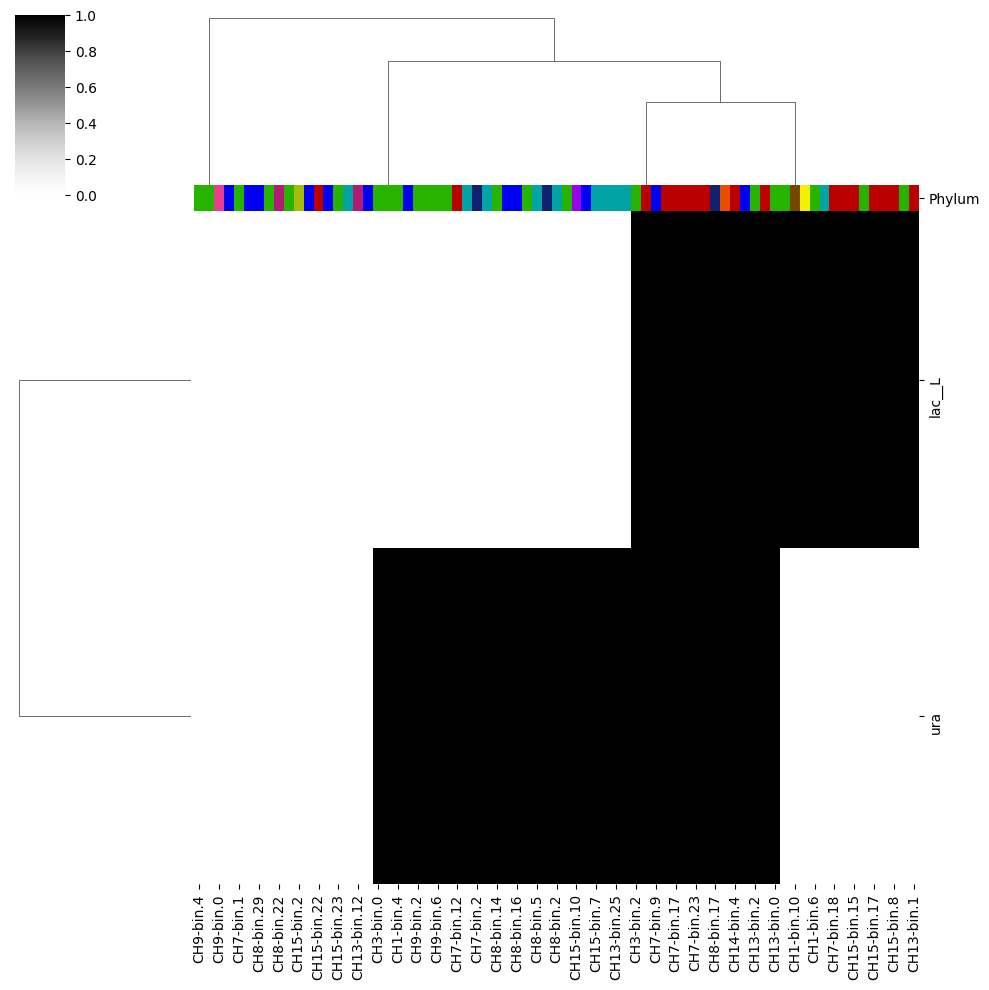

In [72]:
sns.clustermap(data=compound_producer_df.loc[["lac__L","ura"]], cmap="Greys",method="average",metric="jaccard",col_colors=colrs_df,yticklabels=True)

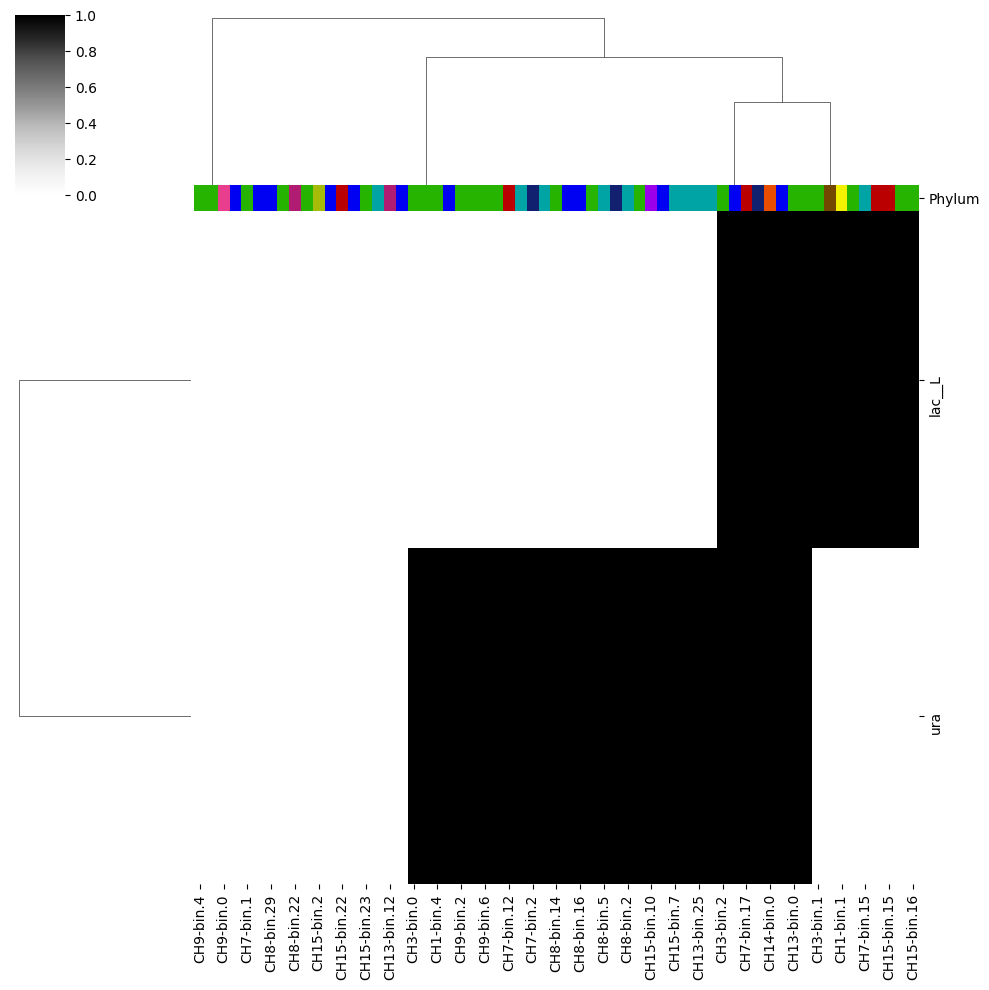

In [73]:
sns.clustermap(data=compound_producer_df.loc[["lac__L","ura"],~compound_producer_df.columns.isin(Desulfovibrionaceae_MAGs)], cmap="Greys",method="average",metric="jaccard",col_colors=colrs_df,yticklabels=True)

### SteadierCom results

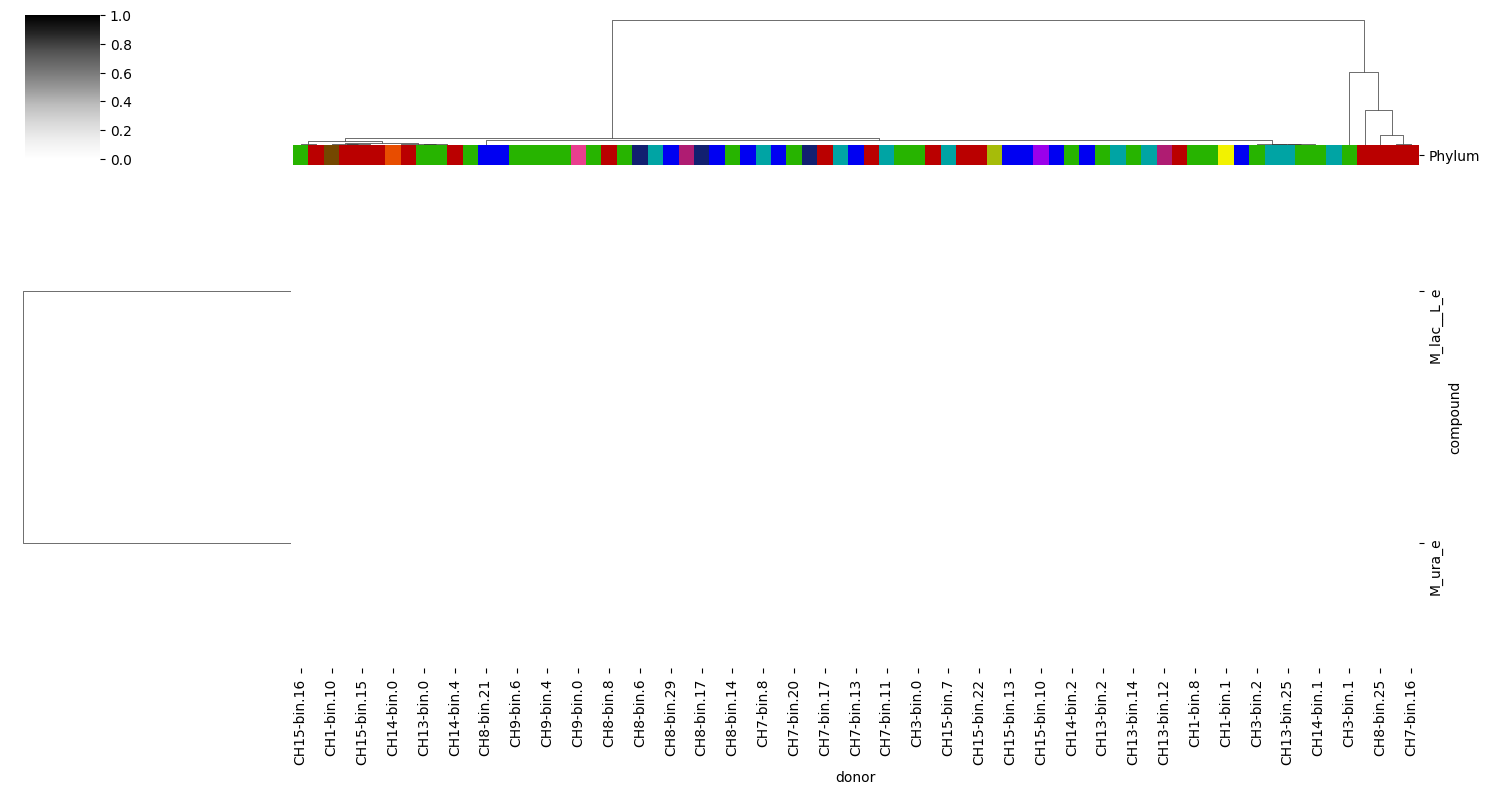

In [74]:

sns.clustermap(figsize=(15,8),data=steadiercom_donor.loc[["M_lac__L_e","M_ura_e"]],cmap="Greys",vmin=0,vmax=1, method="ward",metric="euclidean",col_colors=colrs_df,yticklabels=True)

## 4. Lachnospiraceae thymine dependency in cellulose communities

In [75]:
Lachnospiraceae_cellulose_MAGs = all_mag_paper[(all_mag_paper["Family"]=="Lachnospiraceae") & (all_mag_paper.new_coverage>1) & (all_mag_paper.Substrate!="Xylan")].index


In [76]:
all_mag_paper[(all_mag_paper["Family"]=="Lachnospiraceae") & (all_mag_paper.new_coverage>1) & (all_mag_paper.Substrate!="Xylan")]

,Source,Substrate,Completeness (%),Contamination (%),Domain,Phylum,Class,Order,Family,Genus,Species,Genome size (bp),Scaffolds,N50,CDS prediction (DRAM),Column1,new_coverage
MAG,,,,,,,,,,,,,,,,,
CH15-bin.16,Compost_Digestate,PASC,99.37,2.22,Bacteria,Firmicutes,Clostridia,Lachnospirales,Lachnospiraceae,Lacrimispora,NaN,5604339.0,23.0,423081.0,5254.0,CH15-bin.16,4.253342
CH1-bin.6,Marshland,PASC,99.37,1.90,Bacteria,Firmicutes,Clostridia,Lachnospirales,Lachnospiraceae,Lacrimispora,Lacrimispora sp015057705,5692936.0,27.0,431665.0,5314.0,CH1-bin.6,45.242630
CH1-bin.8,Marshland,PASC,97.11,0.63,Bacteria,Firmicutes,Clostridia,Lachnospirales,Lachnospiraceae,Lacrimispora,Lacrimispora celerecrescens_B,5085002.0,53.0,230023.0,4663.0,CH1-bin.8,3.871541
CH13-bin.14,Compost_Digestate,Avicel,99.37,1.58,Bacteria,Firmicutes,Clostridia,Lachnospirales,Lachnospiraceae,Lacrimispora,Lacrimispora indolis,6707513.0,69.0,164111.0,6104.0,CH13-bin.14,9.628596
CH13-bin.2,Compost_Digestate,Avicel,98.30,2.01,Bacteria,Firmicutes,Clostridia,Lachnospirales,Lachnospiraceae,Mobilitalea,Mobilitalea sp014174405,3801925.0,177.0,37666.0,3385.0,CH13-bin.2,1.019666


### Auxotrophies

In [118]:
Lachnospiraceae_cellulose_auxo={}
Lachnospiraceae_cellulose_auxo2={}

lb_env = reframed.Environment.from_compounds(lb_db.compound.values)
lb_env2 = lb_env.copy()
lb_env2.pop("R_EX_ura_e")
lb_env2["R_EX_thym_e"]=(-1000,0)

In [119]:
for MAG in Lachnospiraceae_cellulose_MAGs:
    model = GEMs_dict[MAG]
    
    lb_env.apply(model,inplace=True,warning=False)
    specific_env = reframed.Environment.from_model(model)
    
    auxo = auxotrophy.auxotrophies(model,specific_env)
    
    Lachnospiraceae_cellulose_auxo[MAG]=auxo
    
    
for MAG in Lachnospiraceae_cellulose_MAGs:
    model = GEMs_dict[MAG]
    
    lb_env2.apply(model,inplace=True,warning=False)
    specific_env2 = reframed.Environment.from_model(model)
    
    auxo = auxotrophy.auxotrophies(model,specific_env2)
    
    Lachnospiraceae_cellulose_auxo2[MAG]=auxo

/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/cobra/auxotrophy.py:18: UserWarning: Organism does not grow in given medium.
  warn("Organism does not grow in given medium.")


In [120]:
summary_auxo = {}

for key,value in Lachnospiraceae_cellulose_auxo.items():
    summary_auxo[key]={}
    for rxn in value:
        summary_auxo[key][rxn]=1
summary_auxo_df = pd.DataFrame(summary_auxo).fillna(0)
summary_auxo_df.loc[~summary_auxo_df.index.isin(["R_EX_"+met+"_e" for met in m9_env_db.compound.values])]

,CH15-bin.16,CH1-bin.6,CH1-bin.8,CH13-bin.14,CH13-bin.2
R_EX_fol_e,1.0,1.0,0.0,0.0,0.0
R_EX_ura_e,1.0,1.0,0.0,1.0,0.0
R_EX_nac_e,0.0,1.0,1.0,1.0,1.0
R_EX_pnto__R_e,0.0,1.0,1.0,1.0,0.0
R_EX_ribflv_e,0.0,0.0,0.0,0.0,1.0


### Minimal medium solutions

In [94]:
Lachnospiraceae_cellulose_minimal_medium={}
n_solutions = 50

lb_env = reframed.Environment.from_compounds(lb_db.compound.values)
lb_env["R_EX_gua_e"]=(-1000,0)
for MAG in Lachnospiraceae_cellulose_MAGs:

    model = GEMs_dict[MAG].copy()
    all_ex_rxns = list(lb_env.keys())                     
    ex_rxns =  [ex_rxn for ex_rxn in all_ex_rxns if ex_rxn in model.reactions]

    min_medium = reframed.cobra.medium.minimal_medium(model=model,exchange_reactions=ex_rxns,use_pool=True,n_solutions=n_solutions)
    
    Lachnospiraceae_cellulose_minimal_medium[MAG]=min_medium

In [95]:
summary = {}
for key, value in Lachnospiraceae_cellulose_minimal_medium.items():
    
    solutions = value[0]
    summary[key]={}
    for solution in solutions:
        
        for element in solution:
            if element in summary[key].keys():
                summary[key][element] +=1
            else:
                summary[key][element] = 1

In [96]:
summary_df = pd.DataFrame(summary).fillna(0).apply(lambda x:x/n_solutions)

summary_df = summary_df.loc[~summary_df.index.isin(m9_env.keys())]#.sort_values(by="sum_all",ascending=False)

rxn2met["R_EX_hxan_e"] = "M_hxan_e"
summary_df.index = summary_df.index.map(lambda x: model_uni.metabolites[rxn2met[x]])



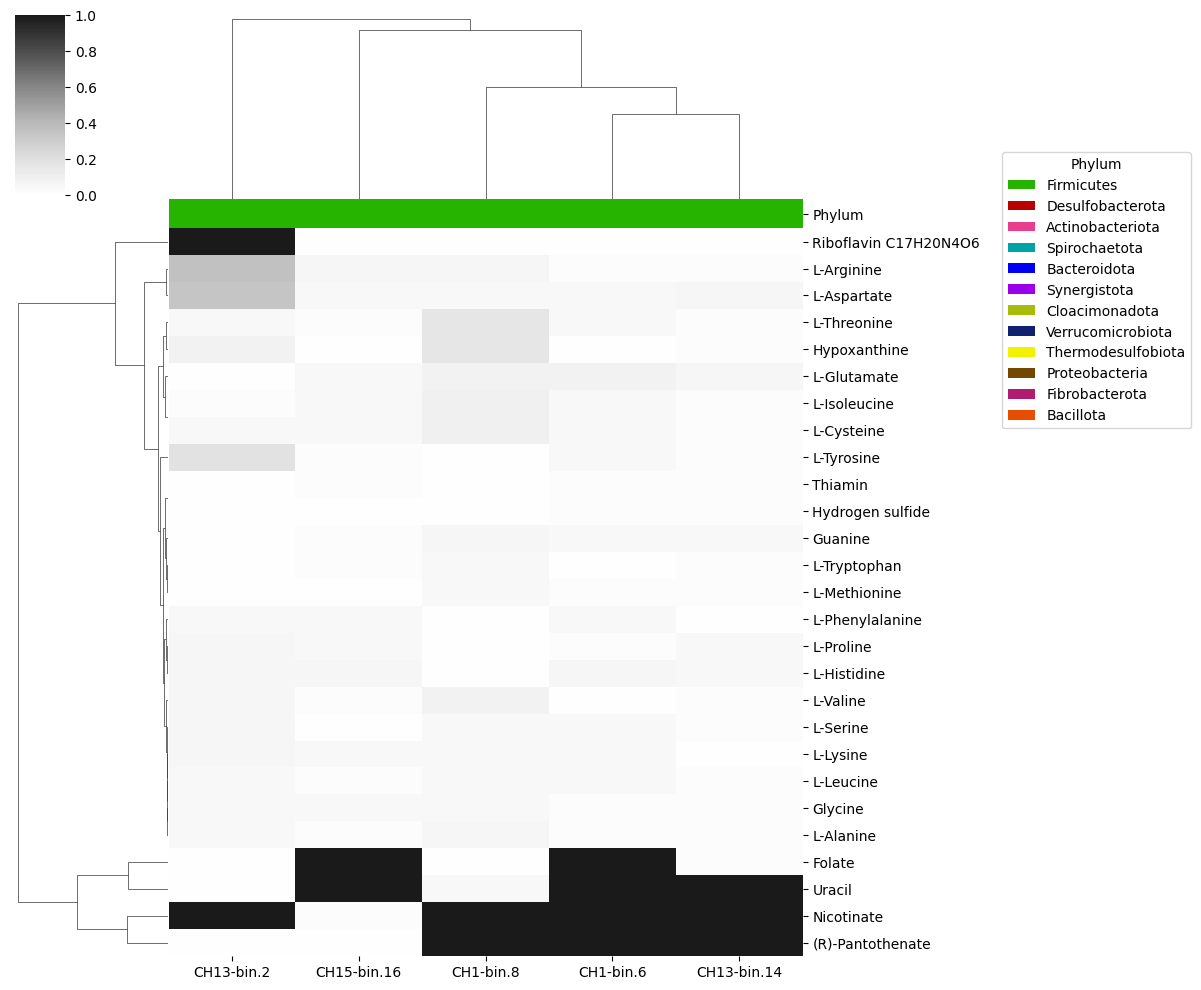

In [99]:
fig = sns.clustermap(data=summary_df, cmap="RdGy",center=0,method="ward",metric="euclidean",col_colors=colrs_df,yticklabels=True)

for label in unique_phyla:
    fig.ax_col_dendrogram.bar(0, 0, color=phyla_lut[label], label=label, linewidth=0)

l1 = fig.ax_col_dendrogram.legend(title='Phylum',ncol=1, bbox_to_anchor=(1.0, 0.85), loc='upper left',bbox_transform=gcf().transFigure)
fig.savefig("Figures/clustermap_auxo_3_4/Lachno_ura_thym.png")

In [91]:
summary_df.loc["R_EX_ura_e",["CH13-bin.2","CH15-bin.16","CH1-bin.6","CH1-bin.8", "CH13-bin.14"]]

CH13-bin.2     0.00
CH15-bin.16    1.00
CH1-bin.6      1.00
CH1-bin.8      0.12
CH13-bin.14    1.00
Name: R_EX_ura_e, dtype: float64

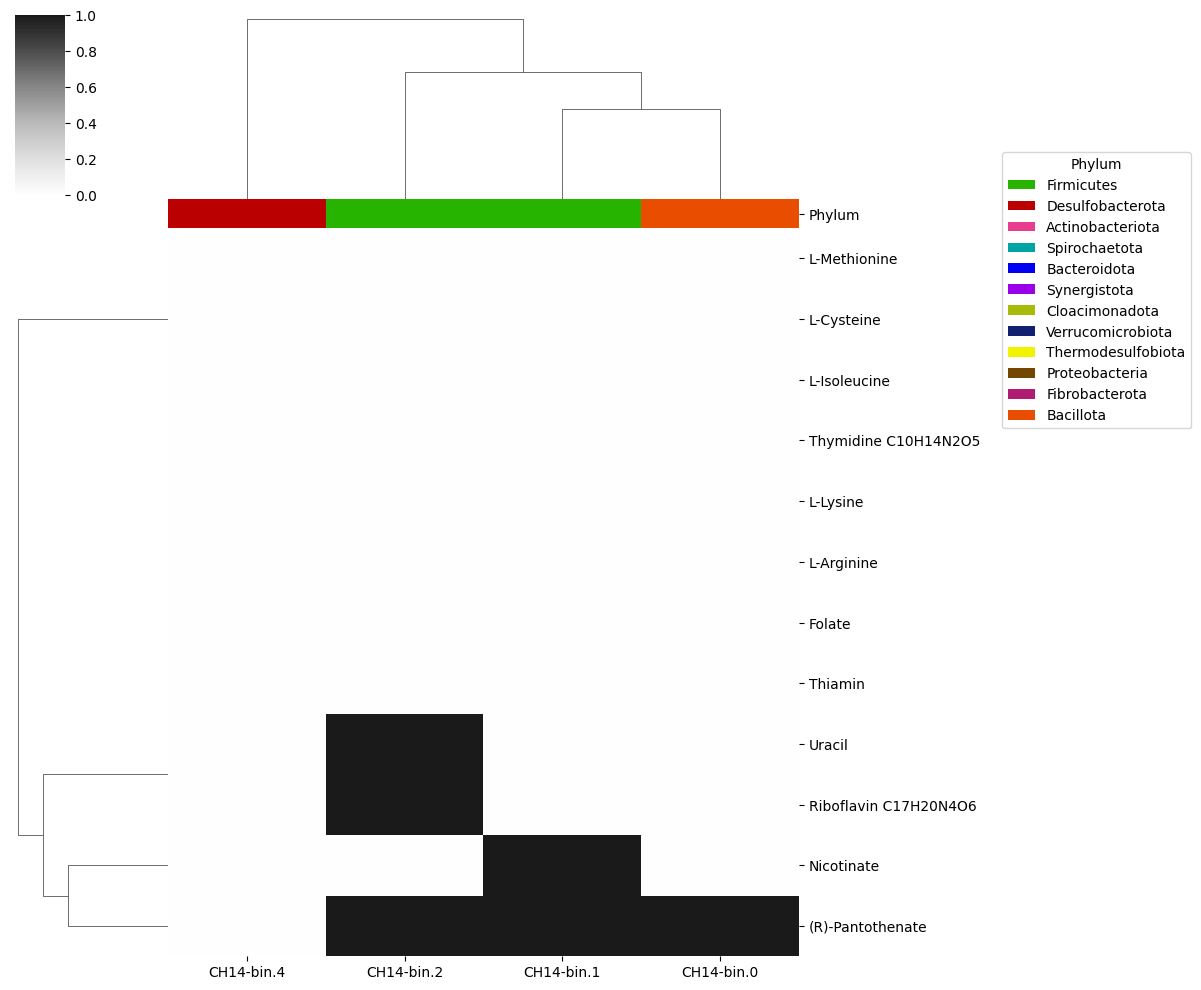

In [14]:
summary_auxo = {}

for key,value in all_gems_auxo.items():
    summary_auxo[key]={}
    for rxn in value:
        summary_auxo[key][rxn]=1
summary_auxo_df = pd.DataFrame(summary_auxo).fillna(0)
summary_auxo_df = summary_auxo_df.loc[~summary_auxo_df.index.isin(["R_EX_"+met+"_e" for met in m9_env_db.compound.values])]
summary_auxo_df = summary_auxo_df.loc[:,summary_auxo_df.columns.str.contains("CH14")]

summary_auxo_df.index = summary_auxo_df.index.map(lambda x: model_uni.metabolites[rxn2met[x]])

fig = sns.clustermap(data=summary_auxo_df, 
               cmap="RdGy",
               center=0,
               method="average",
               metric="jaccard",
               col_colors=colrs_df,
               z_score=None,
               standard_scale=None,
               xticklabels=True,
               yticklabels=True)

for label in unique_phyla:
    fig.ax_col_dendrogram.bar(0, 0, color=phyla_lut[label], label=label, linewidth=0)

l1 = fig.ax_col_dendrogram.legend(title='Phylum',ncol=1, bbox_to_anchor=(1.0, 0.85), loc='upper left',bbox_transform=gcf().transFigure)

fig.savefig("Figures/clustermap_auxo_3_4/auxotrophies_CD_X.png")

### Production of thym and ura from simple medium

In [ ]:

for MAG in Lachnospiraceae_cellulose_MAGs:
    model = GEMs_dict[MAG].copy()
    
    m9_env.apply(model,inplace=True,warning=False)
    specific_env = reframed.Environment.from_model(model)
    print(MAG)
    print(reframed.FBA(model,constraints=specific_env,objective={"R_EX_thym_e":1,"R_Growth":0}))

In [ ]:
m9_env = reframed.Environment.from_compounds(m9_env_db.compound.values)

for MAG in Lachnospiraceae_cellulose_MAGs:
    model = GEMs_dict[MAG].copy()
    
    m9_env.apply(model,inplace=True,warning=False)
    specific_env = reframed.Environment.from_model(model)
    print(MAG)
    print(reframed.FBA(model,constraints=specific_env,objective={"R_EX_ura_e":1,"R_Growth":0}))